# Initialization

In [3]:
# Initialization
import dcor
import numpy as np
import pickle
import itertools
import pandas as pd
import os
import math
from tqdm.notebook import tqdm
from multiprocessing import pool

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import geopandas

from community import community_louvain as community

from dcor._dcor_internals import _u_distance_matrix, u_complementary_projection
from sklearn.manifold import MDS
import gc
import warnings 
warnings.filterwarnings('ignore')

C:\Users\ALIENWARE\anaconda3\envs\tf\lib\site-packages\numba\np\ufunc\parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


In [4]:
std_values = pickle.load(open('C:\\Users\\ALIENWARE\\Desktop\\Utils\\dict_all_i_wb.pkl', 'rb'))

In [5]:
def combinations(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield list(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield list(pool[i] for i in indices)

In [6]:
def combinations_tuple(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield tuple(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield tuple(pool[i] for i in indices)

In [7]:

def product(pool_0, pool_1):
    result = [[x, y]+[z] for x, y in pool_0 for z in pool_1]    # ~ 40 Mio rows
    for prod in result:
        yield tuple(prod)

In [8]:
# loading original and standardised data set
dict_all = pickle.load(open('C:\\Users\\ALIENWARE\\Desktop\\Utils\\dict.pkl', 'rb'))
dict_all_std = pickle.load(open('C:\\Users\\ALIENWARE\\Desktop\\Utils\\dict_std.pkl', 'rb'))
variable=dict_all_std['Darlington'].index

In [9]:
# only take these variables:
#variablenames = ['Economic activity rate - aged 16-64','earnings','Employment rate - aged 16-64','Unemployment rate males - aged 16-64','Unemployment rate females - aged 16-64']
#variablelen = range(45)
variablelen = [1,-6]
# create list out of all unique combinations of goals for the first variablelen of  variables
g_combinations = list(combinations(variable[variablelen], 2))


In [10]:
# adding empty condition set for pairwise dcor
pairs_g1 = pd.DataFrame.from_records(data=g_combinations, columns=['pair_0', 'pair_1'])
pairs_g1['condition'] = '0'

# Data Preparation

In [11]:
# Data Preparation
#data preparation
continents_prep_g = {}

#loading authorityname and dataset
EMPLOYMENT = pd.read_csv("EMPLOYMENT.csv",dtype = "object",na_values=["*","-","!"],skiprows=6)

Employmentall = EMPLOYMENT.dropna(subset=["row"])
a = ['row']
Employmentall = Employmentall[~Employmentall['row'].isin(a)]
Employmentall['year']=0
for i in range(17):
    Employmentall['year'][i*206:(i+1)*206] = 2004+i

#recall authorityname
authoritynames = list(Employmentall['local authority: county / unitary (as of April 2021)'].unique())
#remove the authority with all nan values
authoritynames.remove('Isles of Scilly')

 

# Pairwise distance correlation for unemployment and earning

First define the value of year and its corresponding distance correlation by using distance_cor function 

In [12]:
yearval = range(2008,2021)

def distance_cor(row):
    pair_0, pair_1 = row
    pair_0_mat=np.zeros([len(authoritynames),len(std_values['Darlington'].loc[pair_0,:][4:])])
    pair_1_mat=np.zeros([len(authoritynames),len(std_values['Darlington'].loc[pair_1,:][4:])])
    for ind in range(len(authoritynames)):
        #only take 2008 onwards data
        pair_0_mat[ind] = std_values[authoritynames[ind]].loc['earnings',:][4:]
        pair_1_mat[ind] = std_values[authoritynames[ind]].loc['Unemployment rate - aged 16-64',:][4:]
    
    return dcor.distance_correlation(pair_0_mat, pair_1_mat)**2

In [13]:
dict_cor_goa_c_pair = pairs_g1.drop(columns=['condition']).copy(deep=True)     # pairs_g1 has empty conditional sets for pairwise dcor
dict_cor_goa_c_pair_list = dict_cor_goa_c_pair.values.tolist()

Get the distance correlation value as following code

In [14]:
# continents
dict_cor_goals_continents_2_pair = {}


    
dict_cor_goa_c_pair = pairs_g1.drop(columns=['condition']).copy(deep=True)     # pairs_g1 has empty conditional sets for pairwise dcor
    
#pool = mp.Pool(int(mp.cpu_count()/2))
    
print('start dcor...')
    
dict_cor_goa_c_pair_list = dict_cor_goa_c_pair.values.tolist()
    
cor_results = np.zeros(len(dict_cor_goa_c_pair_list))
for i in range(len(dict_cor_goa_c_pair_list)):
        cor_results[i] = distance_cor(dict_cor_goa_c_pair_list[i])

#pool.close()
#pool.join()

dict_cor_goa_c_pair['dcor_pair'] = cor_results
    
print('...dcor done')
    
dict_cor_goals_continents_2_pair= dict_cor_goa_c_pair

start dcor...
...dcor done


Also find the p-value to check the significance of such pairwise distance correlation:

In [15]:

dict_cor_goals_continents_2_pair['p-value'] = -1
        
# preparing pair_0 and pair_1
             
    
pair_0_mat=np.zeros([len(authoritynames),len(std_values['Darlington'].loc['earnings',:][4:])])
pair_1_mat=np.zeros([len(authoritynames),len(std_values['Darlington'].loc['Unemployment rate - aged 16-64',:][4:])])
for ind in range(len(authoritynames)):
        #only take 2008 onwards data
        pair_0_mat[ind] = std_values[authoritynames[ind]].loc['earnings',:][4:]
        pair_1_mat[ind] = std_values[authoritynames[ind]].loc['Unemployment rate - aged 16-64',:][4:]
        
    
dict_cor_goals_continents_2_pair.loc[0,'p-value'] = dcor.independence.distance_covariance_test(np.array(pair_0_mat).astype(float), np.array(pair_1_mat).astype(float), num_resamples=10000).p_value

In [16]:
#check
dict_cor_goals_continents_2_pair

,pair_0,pair_1,dcor_pair,p-value
0,Employment rate - aged 16-64,earnings,0.187912,0.0011


# Data extraction for councils for specific year period for unemployment
As required in the first point of email, can see the historic data of each variable of each authority/council as a vector (or time-series). Instead of ten year period, the dataset is able to produce a 13-year-period time series dataset for each authority. Therefore, choose the time period to be from 2008 to 2020 to include as much information as possible.

In [17]:
#the time period is chosen to be from 2008 to 2020 
time_period_start = 4 #the seventh column of the std_values stands for year 2011

def distance_cor_authority(authority1,authority2):
    #only take ten year data
    pair_0_array = std_values[authority1].loc['earnings',:][time_period_start:]
    pair_1_array = std_values[authority2].loc['Unemployment rate - aged 16-64',:][time_period_start:]
    p_value = dcor.independence.distance_covariance_test(np.array(pair_0_array).astype(float), np.array(pair_1_array).astype(float), num_resamples=10000).p_value
    return [dcor.distance_correlation(pair_0_array, pair_1_array)**2,p_value]

# Find all pairs of condition set that makes the correlation independent

Here, we consider both partial distance correlation and pairwise distance correlation by looping over specific condition dataset. The dataset is set by usage of combination function defined in the initialization section. We also consider the special case when condition dataset is empty (which is exactly pairwise distance correlation). 

First, we proceed step 1, where we find all potential pairs of condition set. We take all the variables that accounts for all genders.

In [18]:
variable

Index(['Economic activity rate - aged 16-64', 'Employment rate - aged 16-64',
       '% aged 16-64 who are employees', '% aged 16-64 who are self employed',
       'Unemployment rate - aged 16-64', 'Unemployment rate - aged 16+',
       '% who are economically inactive - aged 16-64',
       '% of economically inactive who want a job',
       '% of economically inactive who do not want a job',
       'Economic activity rate males - aged 16-64',
       'Employment rate males - aged 16-64',
       '% of males aged 16-64 who are employees',
       '% of males aged 16-64 who are self employed',
       'Unemployment rate males - aged 16-64',
       'Unemployment rate males - aged 16+',
       '% of  males who are economically inactive - aged 16-64',
       '% of economically inactive males who want a job',
       '% of economically inactive males who do not want a job',
       'Economic activity rate females - aged 16-64',
       'Employment rate females - aged 16-64',
       '% of females a

In [19]:
#this accounts for all variables without unemployment and earnings
#variablelen = [0, 27,-3]
variablelen = [0, 27, 28, 29, 30, 31,32,33,34,35, 39,-9, -3 ]
#number of total variables
len(variablelen)

13

In [20]:
# create list out of all unique combinations of goals for combinations
conditions_g = []
conditions_g_tuple = []
#here consider all combination
for i in range(1, len(variablelen)+1):
    conditions_g.extend(list(combinations(variable[variablelen], i)))
    conditions_g_tuple.extend(tuple(combinations_tuple(variable[variablelen], i)))

pairs = list(product(g_combinations, conditions_g_tuple))
pairs_g0 = pd.DataFrame.from_records(pairs, columns=['pair_0', 'pair_1', 'condition'])


In [21]:
#how many number of combinations
print(len(pairs_g0))

8191


By having the condition pairs, we can get the corresponding partial distance correlation and p value. Here we consider partial distance correlation for non empty condition set:

### Partial distance correlation with condition set 

First, define the partial distance correlation:

In [20]:
def partial_distance_cor(cond,conditions_dict):
    pair_0_mat=np.zeros([len(authoritynames),len(std_values['Darlington'].loc['earnings',:][4:])])
    pair_1_mat=np.zeros([len(authoritynames),len(std_values['Darlington'].loc['Unemployment rate - aged 16-64',:][4:])])
    for ind in range(len(authoritynames)):
        #only take 2008 onwards data
        pair_0_mat[ind] = std_values[authoritynames[ind]].loc['earnings',:][4:]
        pair_1_mat[ind] = std_values[authoritynames[ind]].loc['Unemployment rate - aged 16-64',:][4:]
        
    #condition_array = conditions_dict[str(cond)].T
    condition_array = conditions_dict[str(cond)]
    
    #return dcor.partial_distance_correlation(pair_0_mat.T, pair_1_mat.T, condition_array)**2
    return dcor.partial_distance_correlation(pair_0_mat, pair_1_mat, condition_array)


In [21]:
def partial_distance_pval(cond,conditions_dict):
    pair_0_mat=np.zeros([len(authoritynames),len(std_values['Darlington'].loc['earnings',:][4:])])
    pair_1_mat=np.zeros([len(authoritynames),len(std_values['Darlington'].loc['Unemployment rate - aged 16-64',:][4:])])
    for ind in range(len(authoritynames)):
        #only take 2008 onwards data
        pair_0_mat[ind] = std_values[authoritynames[ind]].loc['earnings',:][4:]
        pair_1_mat[ind] = std_values[authoritynames[ind]].loc['Unemployment rate - aged 16-64',:][4:]
        
    #condition_array = conditions_dict[str(cond)].T
    condition_array = conditions_dict[str(cond)]
    cond_array = np.asarray(condition_array).astype(float)
    
    #return dcor.independence.partial_distance_covariance_test(np.array(pair_0_mat.T).astype(float), np.array(pair_1_mat.T).astype(float), cond_array, num_resamples=1000).p_value 
    return dcor.independence.partial_distance_covariance_test(np.array(pair_0_mat).astype(float), np.array(pair_1_mat).astype(float), cond_array, num_resamples=1000).p_value 



We also need to prepare the array values for condtion set

In [22]:
def authoritycondition ():# preparing conditional set
    conditions_dict = {}
    for cond in tqdm(conditions_g_tuple):
        #for cond in conditions_g_tuple_4:
        #first create a zero vector with length = 2020-2008+1=13
        condition = np.zeros([205,1])
        #condition = []
        for c in cond:   
            pair_mat=np.zeros([len(authoritynames),len(std_values['Darlington'].loc[c,:][4:])])
            #only take 2008 onwards data so starts from the 5th value for each row in time series
            #condition.extend(std_values[authority].loc[c][4:].T)
            for ind in range(len(authoritynames)):
                #only take 2008 onwards data
                pair_mat[ind] = (std_values[authoritynames[ind]].loc[c,:][4:])
            
            
            #vertically append all values so that each column corresponds to different condition of different years
            condition = np.column_stack((condition,pair_mat))
        
        conditions_dict[str(cond)] = condition[:,1:]
        #conditions_dict[str(cond)] = condition
    #conditions_dict[str(cond)] = np.asarray(condition)
    return conditions_dict

Here we create dict_cor_pdcor to store all these values in such dictionary. Each have condition list as one column, pdcor as another column and p-value as the last column. 

In [23]:

#Get conditions
conditions_dict = authoritycondition()
#check condition shape
print(conditions_dict["('% all in employment who are - 4: administrative and secretarial occupations (SOC2010)', '% all in employment who are - 8: process, plant and machine operatives (SOC2010)', 'population_density')"].shape)

#there is an extra line here for the pairwise correlation case: empty condition set
dict_cor_pdcor = pd.DataFrame(index=range(len(pairs_g0)+1), columns=['condition_list', 'dcor','p-value'])
    
for i in range(len(pairs_g0)):
    dict_cor_pdcor.loc[i,'condition_list'] = pairs_g0.loc[i,'condition']
    dict_cor_pdcor.loc[i,'dcor'] = partial_distance_cor(pairs_g0.loc[i,'condition'],conditions_dict)
    dict_cor_pdcor.loc[i,'p-value'] = partial_distance_pval(pairs_g0.loc[i,'condition'],conditions_dict)

  0%|          | 0/8191 [00:00<?, ?it/s]

(205, 39)


Former analysis consider non empty condition set. Here we consider pairse distance correlation for empty condition set:



In [24]:
for authority in authoritynames:
    #here the condition set is empty, say 0
    dict_cor_pdcor.loc[len(pairs_g0),'condition_list']=0
    #here the dcor value is pairwise distance correlation
    dict_cor_pdcor.loc[len(pairs_g0),'dcor'] = dict_cor_goals_continents_2_pair.loc[0,'dcor_pair'] 
    dict_cor_pdcor.loc[len(pairs_g0),'p-value'] = dict_cor_goals_continents_2_pair.loc[0,'p-value'] 

    


In [25]:
dict_cor_pdcor

,condition_list,dcor,p-value
0,"(Economic activity rate - aged 16-64,)",0.009406,0.083916
1,"(% all in employment who are - 1: managers, di...",0.009487,0.087912
2,(% all in employment who are - 2: professional...,0.009416,0.086913
3,(% all in employment who are - 3: associate pr...,0.009457,0.083916
4,(% all in employment who are - 4: administrati...,0.009404,0.115884
...,...,...,...
8187,"(Economic activity rate - aged 16-64, % all in...",0.009222,0.095904
8188,"(Economic activity rate - aged 16-64, % all in...",0.009315,0.093906
8189,"(% all in employment who are - 1: managers, di...",0.009269,0.075924
8190,"(Economic activity rate - aged 16-64, % all in...",0.00926,0.095904


In [26]:
dict_cor_pdcor.iloc[:13,:]

,condition_list,dcor,p-value
0,"(Economic activity rate - aged 16-64,)",0.009406,0.083916
1,"(% all in employment who are - 1: managers, di...",0.009487,0.087912
2,(% all in employment who are - 2: professional...,0.009416,0.086913
3,(% all in employment who are - 3: associate pr...,0.009457,0.083916
4,(% all in employment who are - 4: administrati...,0.009404,0.115884
5,(% all in employment who are - 5: skilled trad...,0.009405,0.084915
6,"(% all in employment who are - 6: caring, leis...",0.009272,0.110889
7,(% all in employment who are - 7: sales and cu...,0.009473,0.085914
8,"(% all in employment who are - 8: process, pla...",0.009397,0.098901
9,(% all in employment who are - 9: elementary o...,0.009468,0.112887


In [27]:
#condition set combining all conditions
dict_cor_pdcor.iloc[-2,:]

condition_list    (Economic activity rate - aged 16-64, % all in...
dcor                                                        0.00926
p-value                                                    0.095904
Name: 8190, dtype: object

# Identify the condition list that makes the unemployment rate and earning no longer significant

The condition set which we are interested in are the set with p-value that is no longer significant. i.e. p-value>0.05.

Some condition set may make p-value no longer significant in some authority but not the other. Therefore, I will try to identify all the condition set that makes correlation non-significant in all authority to make sure it has the generalized property. 

In [28]:
len(pairs_g0.loc[:,'condition'])

8191

In [29]:
#Store all the condition set that are interested (makes correlation no longer significant)
nonsig_conditionset = []

#Identify the condition set that has p-value >0.05 for all authority
for cond_num in range(len(pairs_g0.loc[:,'condition'])):
    if dict_cor_pdcor.loc[cond_num,'p-value'] > 0.05:
        #append it to the list of nonsig_conditionset
        nonsig_conditionset.append([pairs_g0.loc[:,'condition'][cond_num],dict_cor_pdcor.loc[cond_num,'p-value']])
           
nonsig_conditionset[-1]

[('Economic activity rate - aged 16-64',
  '% all in employment who are - 1: managers, directors and senior officials (SOC2010)',
  '% all in employment who are - 2: professional occupations (SOC2010)',
  '% all in employment who are - 3: associate prof & tech occupations (SOC2010)',
  '% all in employment who are - 4: administrative and secretarial occupations (SOC2010)',
  '% all in employment who are - 5: skilled trades occupations (SOC2010)',
  '% all in employment who are - 6: caring, leisure and other service occupations (SOC2010)',
  '% all in employment who are - 7: sales and customer service occupations (SOC2010)',
  '% all in employment who are - 8: process, plant and machine operatives (SOC2010)',
  '% all in employment who are - 9: elementary occupations (SOC2010)',
  '% with NVQ4+ - aged 16-64',
  '% of all people aged 16+ who are male',
  'population_density'),
 0.0959040959040959]

In [30]:
len(nonsig_conditionset)

8191

It can be shown that all pairs considered are non-significant. The result will be discussed in the paper

# Individual authority level

The previous study has focus the correlation between unemployment and earning in an overall level with respect to all authority. It might be a good idea to focus the correlation between unemployment and earning in authority level. For each authority, we calculate the correlation based on the time serie data of 13 years and visualize it using geopandas.

In [22]:
#there is an extra line here for the pairwise correlation case: empty condition set
authority_dict_cor_dcor = pd.DataFrame(index=range(len(authoritynames)), columns=['authorityname', 'dcor','p-value'])

for i in range(len(authoritynames)):
    authority_dict_cor_dcor.iloc[i,1] = dcor.distance_correlation(std_values[authoritynames[i]].iloc[4,4:],std_values[authoritynames[i]].iloc[-6,4:])**2
    authority_dict_cor_dcor.iloc[i,2] = dcor.independence.distance_covariance_test(np.array(std_values[authoritynames[i]].iloc[4,4:]).astype(float), np.array(std_values[authoritynames[i]].iloc[-6,4:]).astype(float), num_resamples=10000).p_value
    authority_dict_cor_dcor.iloc[i,0] = authoritynames[i]          
                                          

In [23]:
authority_dict_cor_dcor

,authorityname,dcor,p-value
0,Darlington,0.471686,0.022698
1,County Durham,0.501586,0.014299
2,Hartlepool,0.40089,0.040696
3,Middlesbrough,0.490078,0.013099
4,Northumberland,0.192576,0.548845
...,...,...,...
200,South Ayrshire,0.307253,0.114989
201,South Lanarkshire,0.501119,0.011199
202,Stirling,0.585619,0.004
203,West Dunbartonshire,0.671703,0.0015


### For visualization 

<AxesSubplot:>

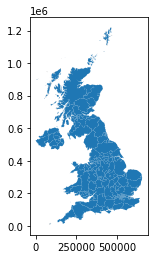

In [33]:
#create a plotting for authority
authority = geopandas.read_file('CTYUA_DEC_2021_UK_BFC.shp')
authority.plot()

However, in such file, there are some authority that is inconsistent with the one we calculated. Therefore, need to manually assert data into the correspondant authority in shape file.

In [34]:
#initialize empty set
inauthoritylistdcor = np.zeros(len(authority['CTYUA21NM']))
#loop over all authority
for i in range(len(authority['CTYUA21NM'])):
    for j in range(len(authoritynames)):
        #if authorityname corresponds, get the value
        if authority['CTYUA21NM'][i]==authority_dict_cor_dcor.iloc[j,0]:
            inauthoritylistdcor[i]=authority_dict_cor_dcor.iloc[j,1]
            break
authority['dcor'] = inauthoritylistdcor
authority = authority[authority['dcor']!=0]





<AxesSubplot:>

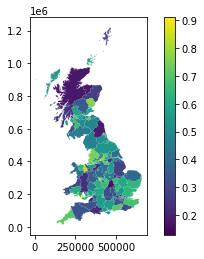

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

authority.plot(column='dcor', ax=ax, legend=True)

## Now consider partial distance correlation for all related conditions


In [27]:
#there is an extra line here for the pairwise correlation case: empty condition set
authority_dict_cor_pdcor = pd.DataFrame(index=range(len(authoritynames)), columns=['authorityname', 'pdcor','p-value'])


for i in range(len(authoritynames)):
    #initialize condition matrix to store 13 years of data for authority i with the value conresponding the variable 
    condition_mat = np.zeros([13,len(variablelen)])
    for j in range(len(variablelen)):
        condition_mat[:,j] = std_values[authoritynames[i]].iloc[j,4:]
    authority_dict_cor_pdcor.iloc[i,1] = dcor.partial_distance_correlation(std_values[authoritynames[i]].iloc[4,4:],std_values[authoritynames[i]].iloc[-6,4:],condition_mat)**2
    authority_dict_cor_pdcor.iloc[i,2] = dcor.independence.partial_distance_covariance_test(np.array(std_values[authoritynames[i]].iloc[4,4:]).astype(float), np.array(std_values[authoritynames[i]].iloc[-6,4:]).astype(float), condition_mat, num_resamples=1000).p_value 
    authority_dict_cor_pdcor.iloc[i,0] = authoritynames[i]          
                                          

In [28]:
authority_dict_cor_pdcor

,authorityname,pdcor,p-value
0,Darlington,0.042867,0.057942
1,County Durham,0.033795,0.932068
2,Hartlepool,0.033208,0.071928
3,Middlesbrough,0.035523,0.068931
4,Northumberland,0.005222,0.682318
...,...,...,...
200,South Ayrshire,0.023958,0.101898
201,South Lanarkshire,0.043313,0.04995
202,Stirling,0.261531,0.000999
203,West Dunbartonshire,0.09244,0.013986


### For visualization

Visualize the partial distance correlation:

<AxesSubplot:>

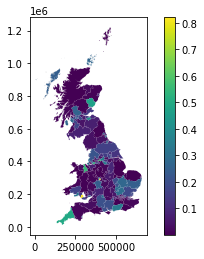

In [36]:
#create a plotting for authority
authority = geopandas.read_file('CTYUA_DEC_2021_UK_BFC.shp')
#initialize empty set
inauthoritylistpdcor = np.zeros(len(authority['CTYUA21NM']))
#loop over all authority
for i in range(len(authority['CTYUA21NM'])):
    for j in range(len(authoritynames)):
        #if authorityname corresponds, get the value
        if authority['CTYUA21NM'][i]==authority_dict_cor_pdcor.iloc[j,0]:
            inauthoritylistpdcor[i]=authority_dict_cor_pdcor.iloc[j,1]
            break
authority['pdcor'] = inauthoritylistpdcor
authority = authority[authority['pdcor']!=0]


fig, ax = plt.subplots(1, 1)
authority.plot(column='pdcor', ax=ax, legend=True)


In [40]:
pvalpdcor = authority_dict_cor_pdcor.iloc[:,1]

idx = np.where(pvalpdcor > 0.6)[0]


print(f'{[authority_dict_cor_pdcor.iloc[i,0] for i in idx]} has correlation {[authority_dict_cor_pdcor.iloc[i,1] for i in idx]} with p value {[authority_dict_cor_pdcor.iloc[i,2] for i in idx]} respectively ')


pvalpdcor = authority_dict_cor_pdcor.iloc[:,1]
idx = np.where(pvalpdcor > 0.4)[0]
print(f'Other authority with high pdcor are: {[authority_dict_cor_pdcor.iloc[i,0] for i in idx]}')
print(f'These area has pvalue {[authority_dict_cor_pdcor.iloc[i,2] for i in idx]}')

['Sandwell', 'Bridgend'] has correlation [0.7699614767551859, 0.8206751989783329] with p value [0.000999000999000999, 0.000999000999000999] respectively 
Other authority with high pdcor are: ['Warrington', 'Oldham', 'Sandwell', 'Cornwall', 'Denbighshire', 'Bridgend', 'Angus', 'Midlothian']
These area has pvalue [0.000999000999000999, 0.000999000999000999, 0.000999000999000999, 0.000999000999000999, 0.000999000999000999, 0.000999000999000999, 0.000999000999000999, 0.000999000999000999]
